# Training Neural Networks
Backpropagation is the most common training algorithm for neural networks. It makes gradient descent feasible for multi-layer neural networks. TensorFlow handles backpropagation automatically, so you don't need a deep understanding of the algorithm. To get a sense of how it works, walk through the following: [Backpropagation algorithm visual explanation](https://google-developers.appspot.com/machine-learning/crash-course/backprop-scroll/). As you scroll through the preceding explanation, note the following:

- How data flows through the graph.
- How dynamic programming lets us avoid computing exponentially many paths through the graph. Here "dynamic programming" just means recording intermediate results on the forward and backward passes.

# Best Practices

This section explains backpropagation's failure cases and the most common way to regularize a neural network.

### Failure Cases
There are a number of common ways for backpropagation to go wrong.

### Vanishing Gradients
The gradients for the lower layers (closer to the input) can become very small. In deep networks, computing these gradients can involve taking the product of many small terms.

When the gradients vanish toward 0 for the lower layers, these layers train very slowly, or not at all.

The ReLU activation function can help prevent vanishing gradients.

### Exploding Gradients
If the weights in a network are very large, then the gradients for the lower layers involve products of many large terms. In this case you can have exploding gradients: gradients that get too large to converge.

Batch normalization can help prevent exploding gradients, as can lowering the learning rate.

### Dead ReLU Units
Once the weighted sum for a ReLU unit falls below 0, the ReLU unit can get stuck. It outputs 0 activation, contributing nothing to the network's output, and gradients can no longer flow through it during backpropagation. With a source of gradients cut off, the input to the ReLU may not ever change enough to bring the weighted sum back above 0.

Lowering the learning rate can help keep ReLU units from dying.

### Dropout Regularization
Yet another form of regularization, called **Dropout**, is useful for neural networks. It works by randomly "dropping out" unit activations in a network for a single gradient step. The more you drop out, the stronger the regularization:

- 0.0 = No dropout regularization.
- 1.0 = Drop out everything. The model learns nothing.
- Values between 0.0 and 1.0 = More useful.

# Exercise
**Learning Objective:** Improve the performance of a neural network by normalizing features and applying various optimization algorithms

**NOTE:** The optimization methods described in this exercise are not specific to neural networks; they are effective means to improve most types of models.

### Setup

First, we'll load the data.

In [2]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("https://storage.googleapis.com/mledu-datasets/california_housing_train.csv", sep=",")

california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))

In [3]:
def preprocess_features(california_housing_dataframe):
    """Prepares input features from California housing data set.

    Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
    Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
    """
    selected_features = california_housing_dataframe[
        ["latitude",
         "longitude",
         "housing_median_age",
         "total_rooms",
         "total_bedrooms",
         "population",
         "households",
         "median_income"]]
    processed_features = selected_features.copy()
    # Create a synthetic feature.
    processed_features["rooms_per_person"] = (california_housing_dataframe["total_rooms"]/california_housing_dataframe["population"])
    return processed_features

def preprocess_targets(california_housing_dataframe):
    """Prepares target features (i.e., labels) from California housing data set.

    Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
    Returns:
    A DataFrame that contains the target feature.
    """
    output_targets = pd.DataFrame()
    # Scale the target to be in units of thousands of dollars.
    output_targets["median_house_value"] = (california_housing_dataframe["median_house_value"] / 1000.0)
    return output_targets

In [4]:
# Choose the first 12000 (out of 17000) examples for training.
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_targets = preprocess_targets(california_housing_dataframe.head(12000))

# Choose the last 5000 (out of 17000) examples for validation.
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))

# Double-check that we've done the right thing.
print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.5,2633.0,537.3,1424.2,498.8,3.9,2.0
std,2.1,2.0,12.6,2115.5,411.3,1142.5,374.3,1.9,1.1
min,32.5,-124.3,1.0,11.0,3.0,3.0,2.0,0.5,0.0
25%,33.9,-121.8,18.0,1465.0,297.0,789.0,282.0,2.6,1.5
50%,34.2,-118.5,29.0,2135.5,434.5,1164.0,409.0,3.6,1.9
75%,37.7,-118.0,37.0,3142.2,646.0,1712.2,601.0,4.8,2.3
max,42.0,-114.3,52.0,32627.0,6445.0,35682.0,6082.0,15.0,55.2


Validation examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.6,-119.5,28.7,2669.2,544.4,1442.6,507.0,3.9,2.0
std,2.1,2.0,12.6,2327.3,445.1,1160.6,407.9,1.9,1.3
min,32.5,-124.3,2.0,2.0,1.0,6.0,1.0,0.5,0.1
25%,33.9,-121.8,18.0,1451.0,296.0,790.0,280.0,2.5,1.5
50%,34.2,-118.5,29.0,2114.0,432.0,1173.0,409.0,3.5,1.9
75%,37.7,-118.0,37.0,3172.2,656.2,1753.2,612.2,4.8,2.3
max,41.8,-114.5,52.0,37937.0,5471.0,16122.0,5189.0,15.0,52.0


Training targets summary:


,median_house_value
count,12000.0
mean,207.7
std,115.8
min,15.0
25%,120.7
50%,180.7
75%,265.1
max,500.0


Validation targets summary:


,median_house_value
count,5000.0
mean,206.2
std,116.4
min,15.0
25%,118.0
50%,179.4
75%,264.5
max,500.0


### Train the Neural Network

Next, we'll train the neural network.

In [5]:
def construct_feature_columns(input_features):
    """Construct the TensorFlow Feature Columns.

    Args:
    input_features: The names of the numerical input features to use.
    Returns:
    A set of feature columns
    """ 
    return set([tf.feature_column.numeric_column(my_feature) for my_feature in input_features])

In [6]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a neural network model.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
        ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [7]:
def train_nn_regression_model(
    my_optimizer,
    steps,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
    """Trains a neural network regression model.

    In addition to training, this function also prints training progress information,
    as well as a plot of the training and validation loss over time.

    Args:
    my_optimizer: An instance of `tf.train.Optimizer`, the optimizer to use.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    hidden_units: A `list` of int values, specifying the number of neurons in each layer.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.

    Returns:
    A tuple `(estimator, training_losses, validation_losses)`:
      estimator: the trained `DNNRegressor` object.
      training_losses: a `list` containing the training loss values taken during training.
      validation_losses: a `list` containing the validation loss values taken during training.
    """

    periods = 10
    steps_per_period = steps / periods

    # Create a DNNRegressor object.
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    dnn_regressor = tf.estimator.DNNRegressor(
      feature_columns=construct_feature_columns(training_examples),
      hidden_units=hidden_units,
      optimizer=my_optimizer
    )

    # Create input functions.
    training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["median_house_value"], 
                                          batch_size=batch_size)
    predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["median_house_value"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
    predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["median_house_value"], 
                                                    num_epochs=1, 
                                                    shuffle=False)

    # Train the model, but do so inside a loop so that we can periodically assess
    # loss metrics.
    print("Training model...")
    print("RMSE (on training data):")
    training_rmse = []
    validation_rmse = []
    for period in range (0, periods):
        # Train the model, starting from the prior state.
        dnn_regressor.train(
            input_fn=training_input_fn,
            steps=steps_per_period
        )
        # Take a break and compute predictions.
        training_predictions = dnn_regressor.predict(input_fn=predict_training_input_fn)
        training_predictions = np.array([item['predictions'][0] for item in training_predictions])

        validation_predictions = dnn_regressor.predict(input_fn=predict_validation_input_fn)
        validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])

        # Compute training and validation loss.
        training_root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(training_predictions, training_targets))
        validation_root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(validation_predictions, validation_targets))
        # Occasionally print the current loss.
        print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
        # Add the loss metrics from this period to our list.
        training_rmse.append(training_root_mean_squared_error)
        validation_rmse.append(validation_root_mean_squared_error)
    print("Model training finished.")

    # Output a graph of loss metrics over periods.
    plt.ylabel("RMSE")
    plt.xlabel("Periods")
    plt.title("Root Mean Squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(training_rmse, label="training")
    plt.plot(validation_rmse, label="validation")
    plt.legend()

    print("Final RMSE (on training data):   %0.2f" % training_root_mean_squared_error)
    print("Final RMSE (on validation data): %0.2f" % validation_root_mean_squared_error)

    return dnn_regressor, training_rmse, validation_rmse

In [8]:
_ = train_nn_regression_model(
    my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.0007),
    steps=5000,
    batch_size=70,
    hidden_units=[10, 10],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

Training model...
RMSE (on training data):
  period 00 : 159.78
  period 01 : 156.86
  period 02 : 148.81
  period 03 : 140.42
  period 04 : 127.23
  period 05 : 112.33
  period 06 : 106.21
  period 07 : 104.27
  period 08 : 104.19
  period 09 : 102.49
Model training finished.
Final RMSE (on training data):   102.49
Final RMSE (on validation data): 101.38


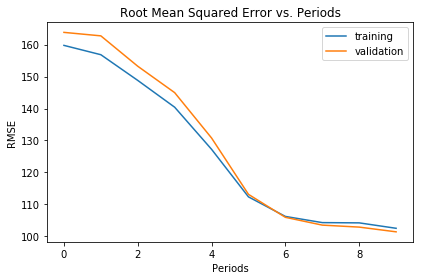

In [11]:
plt.show()

## Linear Scaling
It can be a good standard practice to normalize the inputs to fall within the range -1, 1. This helps SGD not get stuck taking steps that are too large in one dimension, or too small in another. Fans of numerical optimization may note that there's a connection to the idea of using a preconditioner here.

In [9]:
def linear_scale(series):
    min_val = series.min()
    max_val = series.max()
    scale = (max_val - min_val) / 2.0
    return series.apply(lambda x:((x - min_val) / scale) - 1.0)

## Task 1: Normalize the Features Using Linear Scaling

**Normalize the inputs to the scale -1, 1.**

**Spend about 5 minutes training and evaluating on the newly normalized data.  How well can you do?**

As a rule of thumb, NN's train best when the input features are roughly on the same scale.

Sanity check your normalized data.  (What would happen if you forgot to normalize one feature?)


In [10]:
def normalize_linear_scale(examples_dataframe):
    """Returns a version of the input `DataFrame` that has all its features normalized linearly."""
    processed_features = pd.DataFrame()
    processed_features["latitude"] = linear_scale(examples_dataframe["latitude"])
    processed_features["longitude"] = linear_scale(examples_dataframe["longitude"])
    processed_features["housing_median_age"] = linear_scale(examples_dataframe["housing_median_age"])
    processed_features["total_rooms"] = linear_scale(examples_dataframe["total_rooms"])
    processed_features["total_bedrooms"] = linear_scale(examples_dataframe["total_bedrooms"])
    processed_features["population"] = linear_scale(examples_dataframe["population"])
    processed_features["households"] = linear_scale(examples_dataframe["households"])
    processed_features["median_income"] = linear_scale(examples_dataframe["median_income"])
    processed_features["rooms_per_person"] = linear_scale(examples_dataframe["rooms_per_person"])
    return processed_features

In [12]:
normalized_dataframe = normalize_linear_scale(preprocess_features(california_housing_dataframe))
normalized_training_examples = normalized_dataframe.head(12000)
normalized_validation_examples = normalized_dataframe.tail(5000)

_ = train_nn_regression_model(
    my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.0007),
    steps=5000,
    batch_size=70,
    hidden_units=[10, 10],
    training_examples=normalized_training_examples,
    training_targets=training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=validation_targets)

Training model...
RMSE (on training data):
  period 00 : 229.61
  period 01 : 203.90
  period 02 : 154.74
  period 03 : 117.81
  period 04 : 114.14
  period 05 : 110.29
  period 06 : 105.76
  period 07 : 100.38
  period 08 : 94.33
  period 09 : 88.11
Model training finished.
Final RMSE (on training data):   88.11
Final RMSE (on validation data): 89.23


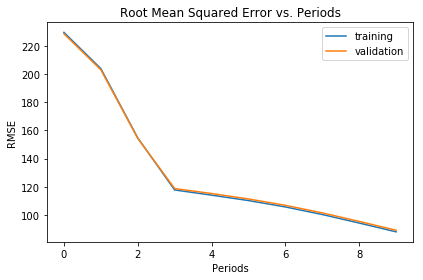

In [13]:
plt.show()

## Task 2: Try a Different Optimizer

** Use the Adagrad and Adam optimizers and compare performance.**

The **Adagrad optimizer** is one alternative. The key insight of Adagrad is that it **modifies the learning rate adaptively for each coefficient in a model**, monotonically lowering the effective learning rate.  This works great for convex problems, but isn't always ideal for the non-convex problem Neural Net training.  You can use Adagrad by specifying `AdagradOptimizer` instead of `GradientDescentOptimizer`.  

*Note that you may need to use a larger learning rate with Adagrad.*

For non-convex optimization problems, **Adam is sometimes more efficient than Adagrad**.  To use Adam, invoke the `tf.train.AdamOptimizer` method. This method takes several optional hyperparameters as arguments, but our solution only specifies one of these (`learning_rate`). In a production setting, you should specify and tune the optional hyperparameters carefully.

In [14]:
_, adagrad_training_losses, adagrad_validation_losses = train_nn_regression_model(
    my_optimizer=tf.train.AdagradOptimizer(learning_rate=0.5),
    steps=500,
    batch_size=100,
    hidden_units=[10, 10],
    training_examples=normalized_training_examples,
    training_targets=training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=validation_targets)

Training model...
RMSE (on training data):
  period 00 : 86.21
  period 01 : 74.36
  period 02 : 72.34
  period 03 : 73.57
  period 04 : 70.30
  period 05 : 70.09
  period 06 : 69.70
  period 07 : 69.61
  period 08 : 69.85
  period 09 : 69.34
Model training finished.
Final RMSE (on training data):   69.34
Final RMSE (on validation data): 69.38


In [15]:
_, adam_training_losses, adam_validation_losses = train_nn_regression_model(
    my_optimizer=tf.train.AdamOptimizer(learning_rate=0.009),
    steps=500,
    batch_size=100,
    hidden_units=[10, 10],
    training_examples=normalized_training_examples,
    training_targets=training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=validation_targets)

Training model...
RMSE (on training data):
  period 00 : 221.06
  period 01 : 137.63
  period 02 : 116.85
  period 03 : 109.22
  period 04 : 98.26
  period 05 : 83.77
  period 06 : 74.03
  period 07 : 71.87
  period 08 : 71.44
  period 09 : 71.69
Model training finished.
Final RMSE (on training data):   71.69
Final RMSE (on validation data): 71.96


In [16]:
plt.ylabel("RMSE")
plt.xlabel("Periods")
plt.title("Root Mean Squared Error vs. Periods")
plt.plot(adagrad_training_losses, label='Adagrad training')
plt.plot(adagrad_validation_losses, label='Adagrad validation')
plt.plot(adam_training_losses, label='Adam training')
plt.plot(adam_validation_losses, label='Adam validation')
_ = plt.legend()

## Task 3: Explore Alternate Normalization Methods

**Try alternate normalizations for various features to further improve performance.**

If you look closely at summary stats for your transformed data, you may notice that linear scaling some features leaves them clumped close to `-1`.

For example, many features have a median of `-0.8` or so, rather than `0.0`.

In [17]:
_ = normalized_training_examples.hist(bins=20, figsize=(18, 12), xlabelsize=10)

We might be able to do better by choosing additional ways to transform these features.

For example, a log scaling might help some features.  Or clipping extreme values may make the remainder of the scale more informative.

In [18]:
def log_normalize(series):
    return series.apply(lambda x:math.log(x+1.0))

def clip(series, clip_to_min, clip_to_max):
    return series.apply(lambda x:(min(max(x, clip_to_min), clip_to_max)))

def z_score_normalize(series):
    mean = series.mean()
    std_dv = series.std()
    return series.apply(lambda x:(x - mean) / std_dv)

def binary_threshold(series, threshold):
    return series.apply(lambda x:(1 if x > threshold else 0))

The block above contains a few additional possible normalization functions. Try some of these, or add your own.

Note that if you normalize the target, you'll need to un-normalize the predictions for loss metrics to be comparable.

In [19]:
def normalize(examples_dataframe):
    """Returns a version of the input `DataFrame` that has all its features normalized."""
    processed_features = pd.DataFrame()

    processed_features["households"] = log_normalize(examples_dataframe["households"])
    processed_features["median_income"] = log_normalize(examples_dataframe["median_income"])
    processed_features["total_bedrooms"] = log_normalize(examples_dataframe["total_bedrooms"])

    processed_features["latitude"] = linear_scale(examples_dataframe["latitude"])
    processed_features["longitude"] = linear_scale(examples_dataframe["longitude"])
    processed_features["housing_median_age"] = linear_scale(examples_dataframe["housing_median_age"])

    processed_features["population"] = linear_scale(clip(examples_dataframe["population"], 0, 5000))
    processed_features["rooms_per_person"] = linear_scale(clip(examples_dataframe["rooms_per_person"], 0, 5))
    processed_features["total_rooms"] = linear_scale(clip(examples_dataframe["total_rooms"], 0, 10000))

    return processed_features

In [20]:
normalized_dataframe = normalize(preprocess_features(california_housing_dataframe))
normalized_training_examples = normalized_dataframe.head(12000)
normalized_validation_examples = normalized_dataframe.tail(5000)

_ = train_nn_regression_model(
    my_optimizer=tf.train.AdagradOptimizer(learning_rate=0.15),
    steps=1000,
    batch_size=50,
    hidden_units=[10, 10],
    training_examples=normalized_training_examples,
    training_targets=training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=validation_targets)

Training model...
RMSE (on training data):
  period 00 : 84.91
  period 01 : 76.14
  period 02 : 72.55
  period 03 : 70.48
  period 04 : 69.90
  period 05 : 68.95
  period 06 : 70.22
  period 07 : 68.51
  period 08 : 68.34
  period 09 : 68.67
Model training finished.
Final RMSE (on training data):   68.67
Final RMSE (on validation data): 67.96


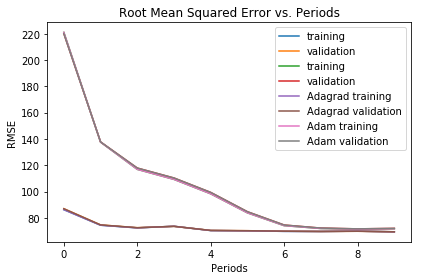

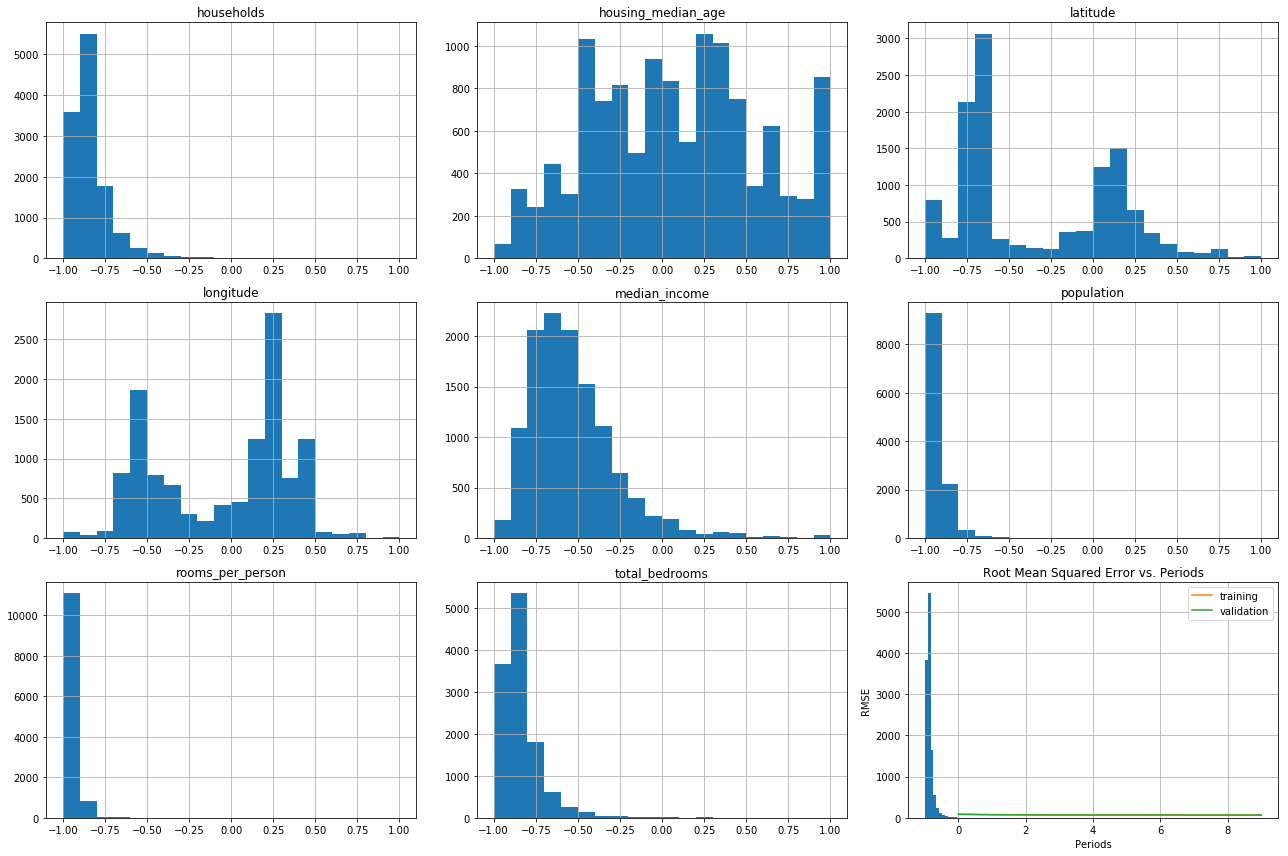

In [21]:
plt.show()